In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime
import seaborn as sns
import pandas as pd
savedate = str(datetime.datetime.now())
t = time.time()

# Setup

In [12]:
# Function to map Wagon to its braking force
brakeforce = lambda Obj : rBF * np.random.normal(1, Obj[1])
#brakeforceExp = lambda Obj : rBF * (1 + kTrain*Obj[2])
brakeforceMC = lambda Obj : rBF * np.random.normal(1, 2*Obj[2], NMC)
#brakeforceMC = lambda Obj : rBF * (1 + np.random.standard_t(1, NMC))
#brakeforceMC = lambda Obj : rBF * (1 + Obj[2]*np.random.standard_t(5,  NMC))

In [55]:
# Train data
NWagonsFleet = 100
NWagonsTrain = 40
NMC = 1000 # Number of MC samples
M = 100 #Trains assembled
N = 10 #Brakings observed per Train

# Wagon data 
# Mass      
mass = 90000
# Brake pad friction
mu = 0.12
# Brake rigging efficiency
eta = 0.81
# Nominal pad braking force
bfNom = 4.8800000e+05
# Maximum standard deviation
sdMax = 0.05
# Resulting retardation force
rBF = bfNom*eta*mu

In [56]:
# Populate train fleet
Fleet = {'Sigma_true': np.random.uniform(low = 0, high = sdMax, size = NWagonsFleet),
         'Sigma_est': 2*np.random.uniform(low = 0, high = sdMax, size = NWagonsFleet),
         'n': np.zeros(NWagonsFleet)}
dffleet = pd.DataFrame(data = Fleet)
dffleet.head()

,Sigma_est,Sigma_true,n
0,0.071203,0.020930,0.0
1,0.093728,0.048391,0.0
2,0.074494,0.002282,0.0
3,0.092280,0.035797,0.0
4,0.084681,0.002829,0.0


In [63]:
# Some lists for simulation
aObsList = []
aNomList = []
relList = []
sdList = []
kList = []
sigmaSave = [[] for k in range(NWagonsFleet)]
bfEst = np.zeros(NWagonsTrain)

for i in range(0, M):
    # Build a train
    WagonsSelected = np.random.choice(range(1, NWagonsFleet+1), size =  NWagonsTrain, replace = False)
    Train = dffleet.iloc[WagonsSelected].as_matrix() ###################
    for i in range(0, N):
        bfTrue = list(map(brakeforce, Train))
        aObs = sum(bfTrue)/(NWagonsTrain * mass)
        aObs = aObs + aObs*np.random.normal(0, 0.05)
        aNom = (NWagonsTrain * rBF)/(NWagonsTrain * mass)
        # Estimate observed brakeforce of train
        bfTrain = aObs*(NWagonsTrain * mass)
        sdTrain = np.mean(np.array(Train)[1:NWagonsTrain, 1])
        kTrain = (aObs/aNom-1)/sdTrain
        bfExp = np.array(list(map(brakeforceMC, Train)))
        bfEst = np.zeros(bfExp.shape,dtype=float)
        for j in range(0, NWagonsTrain):
            # Predict: Estimate each wagon's contribution
            mask = np.ones(NWagonsTrain,dtype=bool)
            mask[j]=0
            bfEst[j] = 1/rBF*(bfTrain - np.sum(bfExp[mask,:],0))
            # Correct
            Fleet[Train[j][0]][3] += 1
            #sigma = np.sqrt((bfEst[j] - rBF)**2/(Fleet[Train[j][0]][3]-1))
            var = np.sqrt(NWagonsTrain)*np.var(bfEst[j,:])
            var2 = Fleet[Train[j][0]][2]**2
            #Fleet[Train[j][0]][2] = 1/(Fleet[Train[j][0]][3])*(Fleet[Train[j][0]][3]*Fleet[Train[j][0]][2] + sigma/rBF/np.sqrt(NWagonsTrain**2))
            Fleet[Train[j][0]][2] = np.sqrt(var*var2/(var+var2))
            sigmaSave[Train[j][0]].append(Fleet[Train[j][0]][2])

KeyError: 0.022910093004317723

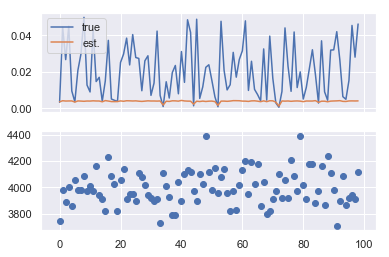

In [43]:
#Plotting
sns.set()
R = range(0,NWagonsFleet-1)
F = np.array(Fleet)
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(R, F[1:NWagonsFleet, 1], label = 'true')
axarr[0].plot(R, F[1:NWagonsFleet, 2], label = 'est.')
axarr[0].legend()
#axarr[0].set_title('Estimated vs. true SD')
axarr[1].scatter(R, F[1:NWagonsFleet, 3])

In [16]:
error = F[1:NWagonsFleet, 2] - F[1:NWagonsFleet, 1]

print('Pearson:', st.pearsonr(F[1:NWagonsFleet, 1],F[1:NWagonsFleet, 2]))
print('RMS: ', np.sqrt(np.dot(error.T, error)))


np.savetxt('TrainSim.dat', F, '%5.5f',  delimiter=' ',   newline='\n', header= 'No SDtrue Sdest n')

    # Save some data
#    aObsList.append(aObs)
#    aNomList.append(aNom)
#    sdList.append(sdTrain)
#    kList.append(kTrain)
#

Pearson: (0.99914550458599649, 0.0)
RMS:  0.859788570413


In [33]:
Fleet[0:2]

[[0, 0.02777415585724337, 0.043141655207528863, 460],
 [1, 0.03646476797945244, 0.052353794272121293, 350]]

In [37]:
Fleet[int(WagonsSelected)]

TypeError: only length-1 arrays can be converted to Python scalars

In [46]:
Fleet

[[0, 0.03146615128940702, 0.06293230257881403, 0],
 [1, 0.010298862711308355, 0.02059772542261671, 0],
 [2, 0.04116954705998492, 0.08233909411996984, 0],
 [3, 0.04956045216945174, 0.09912090433890348, 0],
 [4, 0.0026922643310503093, 0.005384528662100619, 0],
 [5, 0.002374041629257284, 0.004748083258514568, 0],
 [6, 0.03282776752331382, 0.06565553504662763, 0],
 [7, 0.04011488311478967, 0.08022976622957934, 0],
 [8, 0.034528934759612315, 0.06905786951922463, 0],
 [9, 0.04088550048711237, 0.08177100097422474, 0],
 [10, 0.017224678215469618, 0.034449356430939236, 0],
 [11, 0.0035256315722722977, 0.007051263144544595, 0],
 [12, 0.0019968292955741098, 0.0039936585911482195, 0],
 [13, 0.02633960987316372, 0.05267921974632744, 0],
 [14, 0.01971703591766647, 0.03943407183533294, 0],
 [15, 0.010893322403737788, 0.021786644807475577, 0],
 [16, 0.010543657426371068, 0.021087314852742137, 0],
 [17, 0.015068005696935406, 0.03013601139387081, 0],
 [18, 0.038459057863095614, 0.07691811572619123, 0],


In [57]:
dffleet.iloc[WagonsSelected]

,Sigma_est,Sigma_true,n
11,0.006254,0.048465,0.0
2,0.074494,0.002282,0.0
55,0.062978,0.009696,0.0
5,0.014124,0.015274,0.0
36,0.012362,0.045485,0.0
85,0.012295,0.032241,0.0
22,0.022910,0.027915,0.0
21,0.068585,0.022211,0.0
76,0.003156,0.041524,0.0
40,0.012889,0.033040,0.0
